# Object Detection using RetinaNet
We will use the RetinaNet deep learning model to carry object detection in images and videos. We will not be training our own model. Instead, we will use a pre-trained model that PyTorch provides. Using this pre-trained deep learning model, we will be able to detect more than 80 classes of objects that are a part of the COCO dataset.
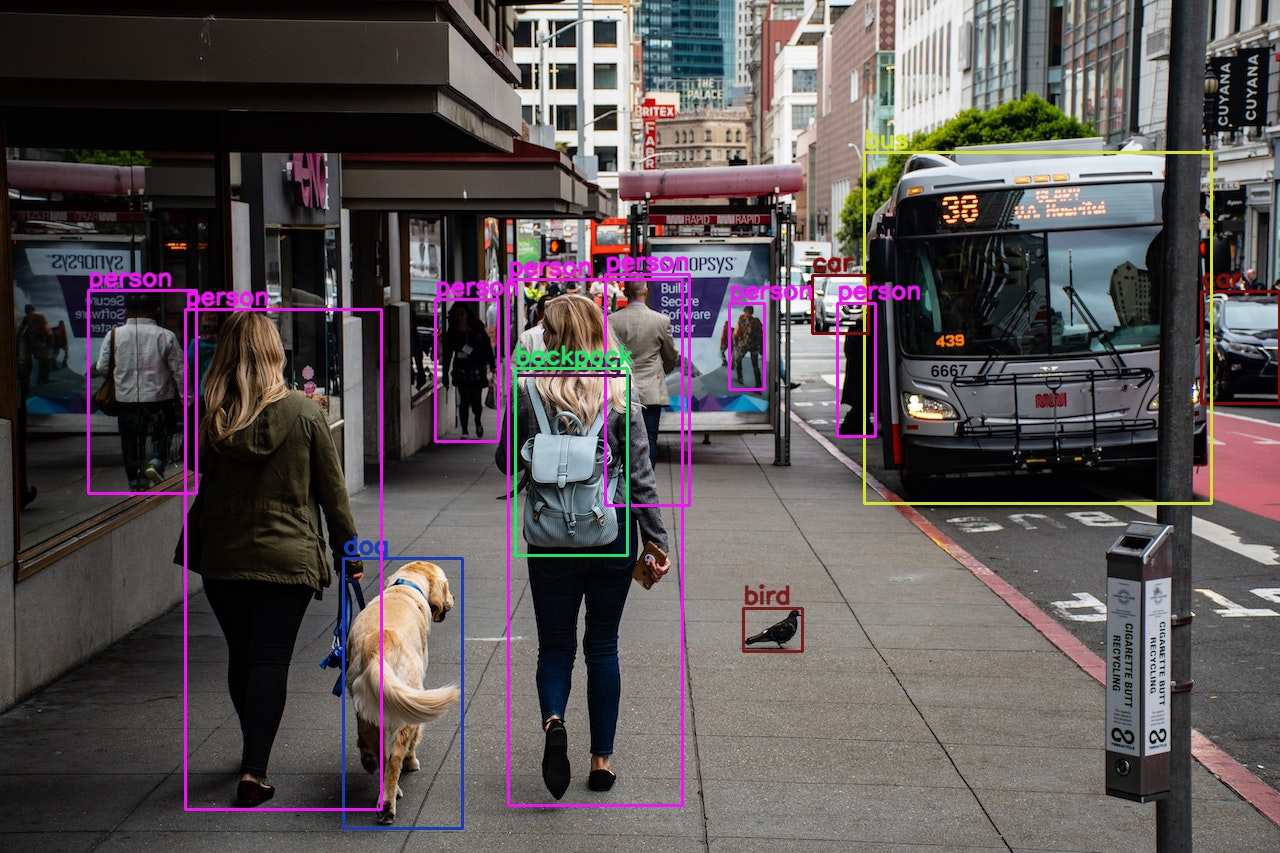

# Let’s start with the imports.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import cv2
import numpy as np
from labels import COCO_INSTANCE_CATEGORY_NAMES as coco_names
import numpy as np
from PIL import Image
import time

In [2]:
# this will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))

In [3]:
# define the torchvision image transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Predict Function
 To get the outputs, we will write a very simple function. We will call this function predict() and this will accept four input parameters. They are the the image, the RetinaNet model, the computation device, and the detection_threshold.

In [4]:
def predict(image, model, device, detection_threshold):
    # transform the image to tensor
    image = transform(image).to(device)
    image = image.unsqueeze(0) # add a batch dimension
    with torch.no_grad():
        outputs = model(image) # get the predictions on the image
    # get all the scores
    scores = list(outputs[0]['scores'].detach().cpu().numpy())
    # index of those scores which are above a certain threshold
    thresholded_preds_inidices = [scores.index(i) for i in scores if i > detection_threshold]
    # get all the predicted bounding boxes
    bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    # get boxes above the threshold score
    boxes = bboxes[np.array(scores) >= detection_threshold].astype(np.int32)
    # get all the predicited class names
    labels = outputs[0]['labels'].cpu().numpy()
    pred_classes = [coco_names[labels[i]] for i in thresholded_preds_inidices]
    return boxes, pred_classes

# Function to Draw the Bounding Boxes Around the Objects
This function accepts three input parameters. The first one is the boxes parameter which contains all the bounding box coordinates that we just extracted from the outputs. The second is the classes parameter containing all the class names. And the final one is the image on which we will draw the boxes and put class names as well.

In [5]:
def draw_boxes(boxes, classes, image):
    for i, box in enumerate(boxes):
        color = COLORS[coco_names.index(classes[i])]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                    lineType=cv2.LINE_AA)
    return image

In [6]:
#path to input image/video
input1='c.jpg'
min_size=1200
#minimum confidence score for detection
threshold=0.5

# Initialize the RetinaNet Model
We will initialize our deep learning RetinaNet object detection model now. Along with that we will also load it into the computation device.

In [7]:
# download or load the model from disk
model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True , min_size=min_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load the model onto the computation device
model.eval().to(device)

C:\Users\mosta\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mosta\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


# Read the Image and Detect the Objects

In [8]:
image = Image.open(input1).convert('RGB')
# a NumPy copy for OpenCV functions
image_array = np.array(image)
# convert to OpenCV BGR color format
image_array = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)

In [9]:
# get the bounding boxes and class labels
boxes, classes = predict(image, model, device, threshold)
# get the final image
result = draw_boxes(boxes, classes, image_array)

In [10]:
cv2.imshow('Image', result)
cv2.waitKey(0)
cv2.destroyAllWindows()


save_name = f"{input1.split('/')[-1].split('.')[0]}_{min_size}_t{int(threshold*100)}"
cv2.imwrite(f"save/{save_name}.jpg", result)

True

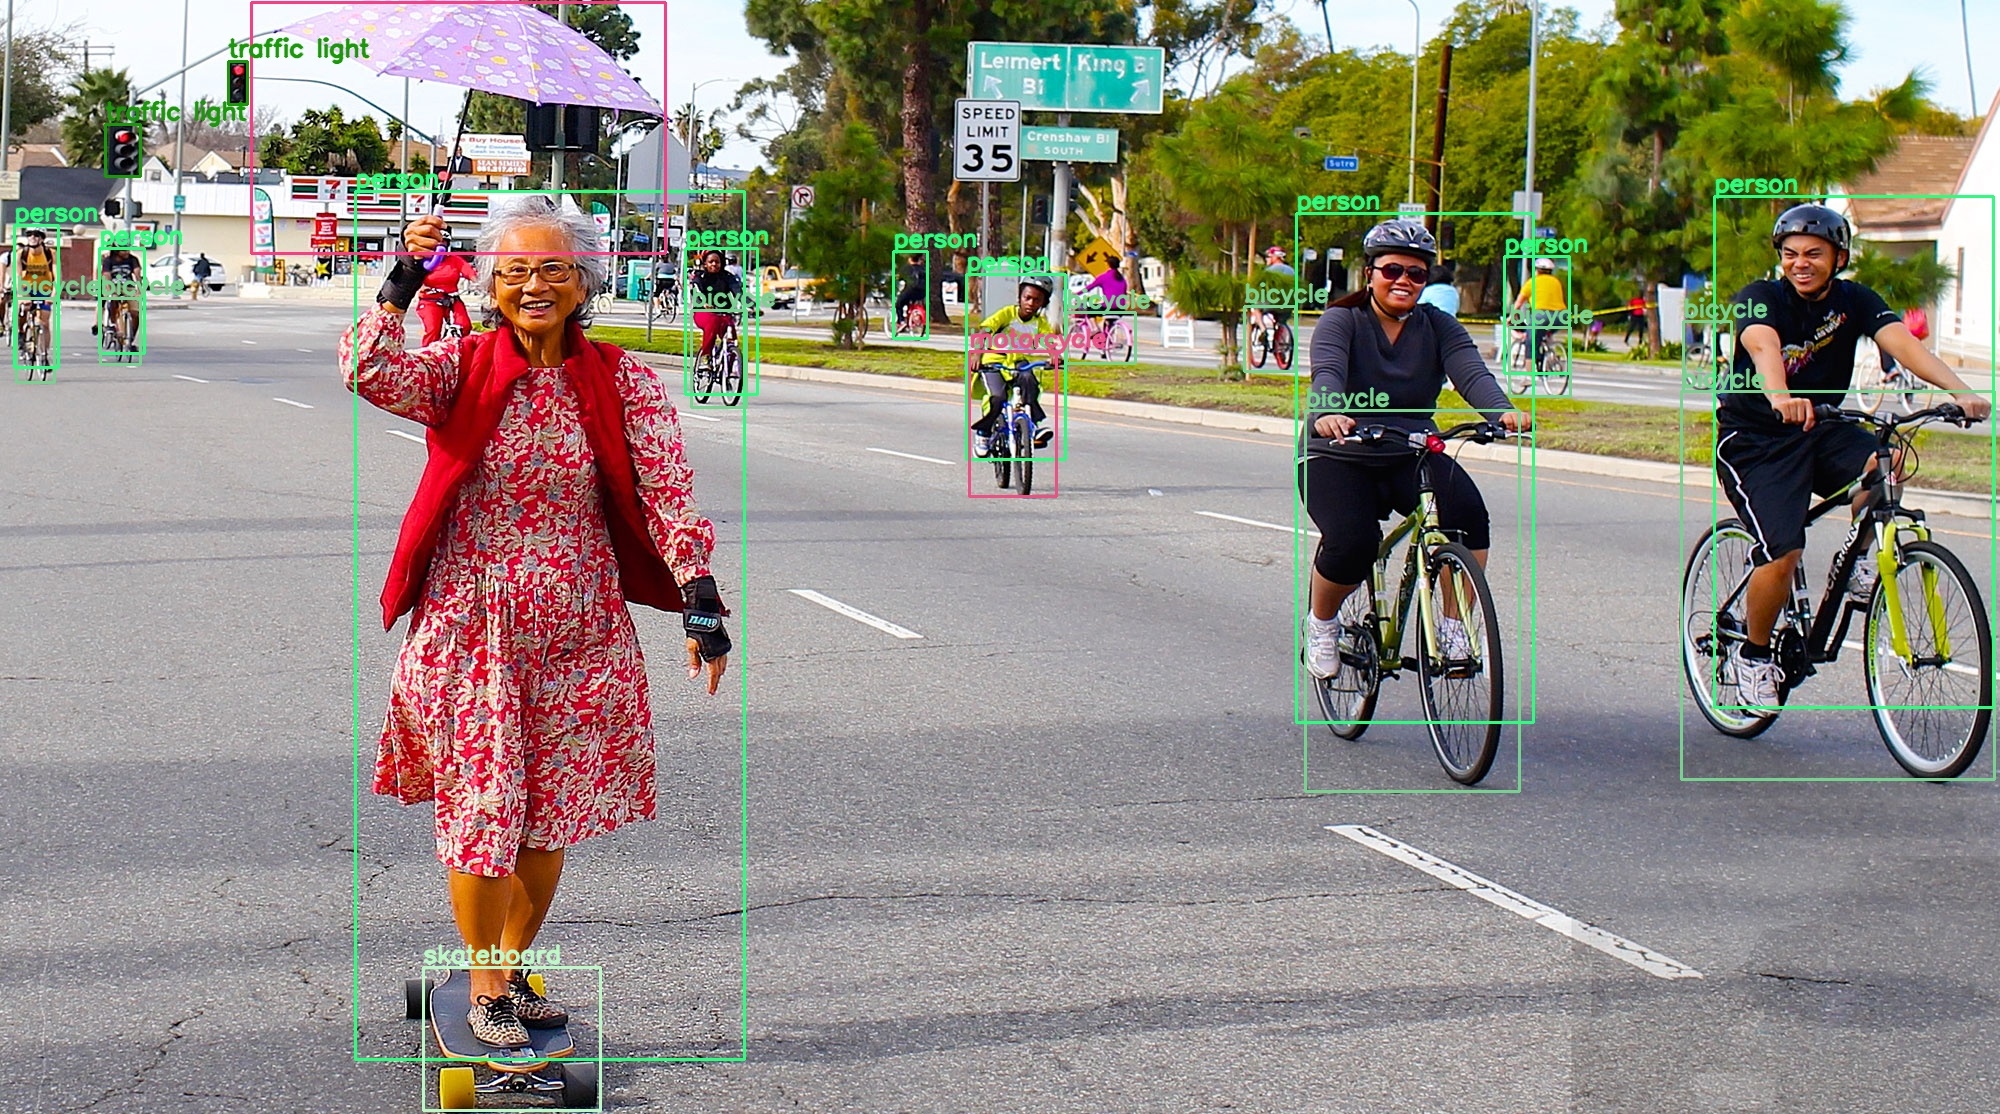

# Using PyTorch RetinaNet for Object Detection in Videos

In [11]:

inputv='2.mp4'
min_sizev=800
thresholdv=0.6

In [12]:
cap = cv2.VideoCapture(inputv)
if (cap.isOpened() == False):
    print('Error while trying to read video. Please check path again')
# get the frame width and height
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
save_name = f"{inputv.split('/')[-1].split('.')[0]}_{min_sizev}_t{int(thresholdv*100)}"
# define codec and create VideoWriter object 
out = cv2.VideoWriter(f"outputs/{save_name}.mp4", 
                      cv2.VideoWriter_fourcc(*'mp4v'), 20, 
                      (frame_width, frame_height))
frame_count = 0 # to count total frames
total_fps = 0 # to get the final frames per second

In [13]:
# read until end of video
while(cap.isOpened()):
    # capture each frame of the video
    ret, frame = cap.read()
    if ret == True:
        # convert the frame into PIL Image format
        pil_image = Image.fromarray(frame).convert('RGB')
        # get the start time
        start_time = time.time()
        
        # get predictions for the current frame
        boxes, classes = predict(pil_image, model, device, threshold)
        # draw boxes and show current frame on screen
        result = draw_boxes(boxes, classes, frame)
        # get the end time
        end_time = time.time()
        # get the fps
        fps = 1 / (end_time - start_time)
        # add fps to total fps
        total_fps += fps
        # increment frame count
        frame_count += 1
        # press `q` to exit
        wait_time = max(1, int(fps/4))
        cv2.imshow('image', result)
        out.write(result)
        if cv2.waitKey(1) == ord('q'):
            break
    else:
        break

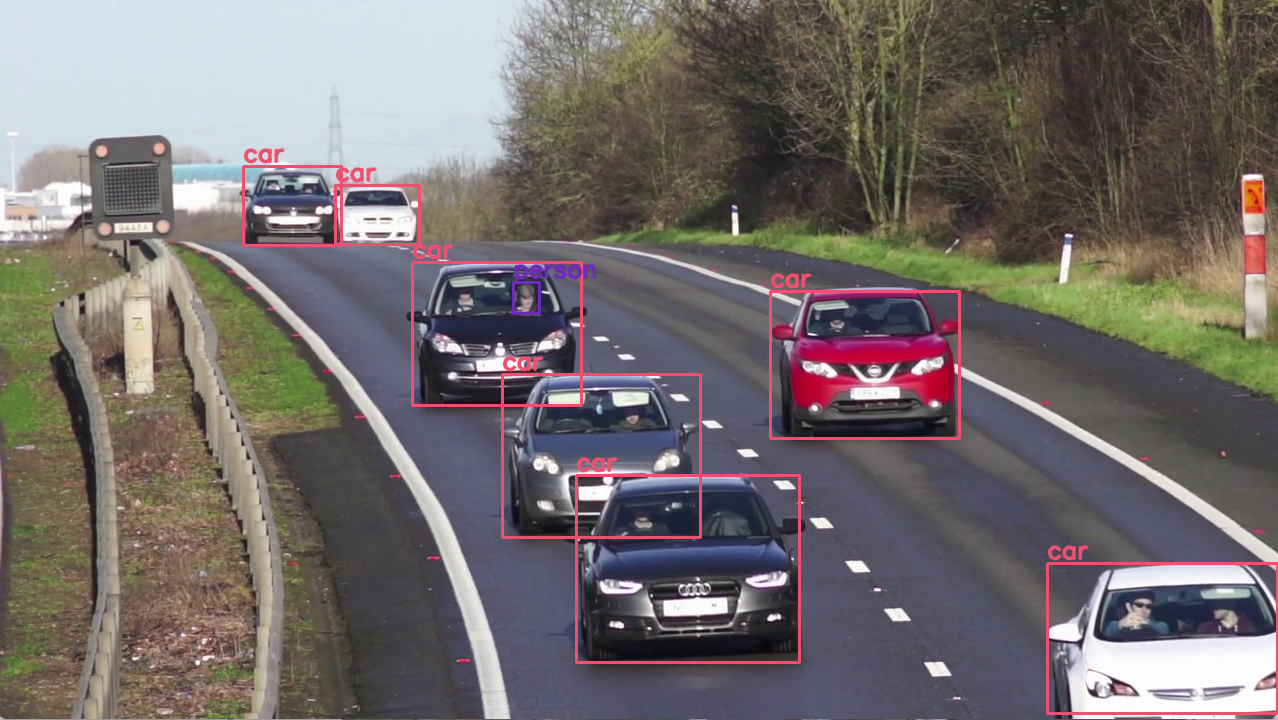